In [27]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import data_preparation 
from p_drought_indices.analysis.DeepLearning.pipeline_convlstm import training_lstm
import pickle
import os
import matplotlib.pyplot as plt
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_split, interpolate_prepare
import numpy as np
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader

CONFIG_PATH = "../config.yaml"
sub_precp, ds = data_preparation(CONFIG_PATH)
sub_precp = sub_precp.to_dataset()
data, target = interpolate_prepare(sub_precp, ds)
train_split = 0.8
training_lstm(CONFIG_PATH, data, target, train_split = train_split)

TypeError: data_preparation() missing 1 required positional argument: 'CONFIG_PATH'

In [ ]:
def data_CHECK(data_array:xr.DataArray):
    # Check shape and size
    print("Shape:", data_array.shape)
    print("Size:", data_array.size)
    
    # Check coordinates and dimensions
    print("Dimensions:", data_array.dims)
    print("Coordinates:", data_array.coords)
    
    # Check data type and values
    print("Data Type:", data_array.dtype)
    print("Data Values:", data_array.values)
    
    # Check for missing values
    print("Missing Values:", data_array.isnull().any())
    
    # Check attributes
    print("Attributes:", data_array.attrs)

In [1]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import data_preparation, get_dataloader, main
from p_drought_indices.analysis.DeepLearning.pipeline_convlstm import training_lstm
import pickle
import os
import matplotlib.pyplot as plt
from p_drought_indices.functions.function_clns import load_config, check_nulls_overtime,\
    prepare, check_timeformat_arrays,  subsetting_pipeline, get_lat_lon_window
import numpy as np
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import xarray as xr


CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
path = config['PRECIP']["ERA5_land"]['path']
late = 60
#file = [f for f in os.listdir(path) if str(late) in f][0]
file = [f for f in os.listdir(path) if f.endswith(".nc")][0]
ndvi_dataset = "smoothed_ndvi.nc"

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Open the precipitation file with xarray
precp_ds = prepare(subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(path, file))))\
    .rio.write_crs(4326, inplace=True)

var_target = [var for var in precp_ds.data_vars][0]
precp_ds[var_target] = precp_ds[var_target].astype(np.float32)

time_end = config['PRECIP']["ERA5_land"]['date_end']
time_start = config['PRECIP']["ERA5_land"]['date_start']
dim = config["GWNET"]["pixels"]
# Open the vegetation file with xarray
dataset = prepare(xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], ndvi_dataset))).rio.write_crs(4326, inplace=True)
dataset["ndvi"] = dataset["ndvi"].astype(np.float32)
dataset = dataset.sel(time=slice(time_start,time_end))[["time","lat","lon","ndvi"]]
sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))

ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})
sub_precp, ds = check_timeformat_arrays(sub_precp[var_target], ds)
sub_precp = sub_precp.where(ds.notnull())

: 

: 

In [19]:
x_df = sub_precp.to_dataframe()
x_df_1 = x_df.swaplevel(1,2)
for col in ["spatial_ref","crs"]:
    if col in x_df_1:
        x_df_1.drop(columns={col}, inplace=True)
x_df_2 = x_df_1.dropna(subset={var_target})
x_df_3 = x_df_2.sort_values(["lat", "lon","time"],ascending=False)
data_x_unstack = x_df_3.unstack(["lat","lon"])
#x_unstack = data_x_unstack.to_numpy()
num_samples, num_nodes = data_x_unstack.shape
x_unstack = np.expand_dims(data_x_unstack, axis=-1)
print("The features have dimensions:", x_unstack.shape)

The features have dimensions: (365, 18608, 1)


In [38]:
y_df = ds.to_dataframe()
for col in ["spatial_ref","crs"]:
    if col in y_df:
        y_df.drop(columns={col}, inplace=True)
y_df1 = y_df.dropna(subset={"ndvi"})
y_df2 = y_df1.sort_values(["lat", "lon","time"],ascending=False)
y_df3 = y_df2.reset_index().set_index(["time","lon","lat"])
y_df4 = y_df3[y_df3.index.isin(x_df_3.index)]
data_y_unstack = y_df4.unstack(["lat","lon"])
y_unstack = data_y_unstack.to_numpy()
y_unstack = np.expand_dims(y_unstack, axis=-1)
print("The instance have dimensions:", y_unstack.shape)

### changes with features
st_df = x_df_3.reset_index()[["lon","lat"]].drop_duplicates()

The instance have dimensions: (365, 18608, 1)


In [57]:
time = y_df.reset_index()["time"].drop_duplicates()
from datetime import datetime
time = [datetime.strftime(i, "%Y-%m-%d") for i in time]

In [22]:
y_df3.unstack(["lat","lon"]).isnull().sum()

      lat    lon      
ndvi   14.8  37.900002    0
       14.7  38.200001    0
             38.099998    0
             38.000000    0
             37.900002    0
                         ..
      -4.5   39.400002    0
             39.099998    0
             39.000000    0
      -4.6   39.400002    0
             39.200001    0
Length: 18663, dtype: int64

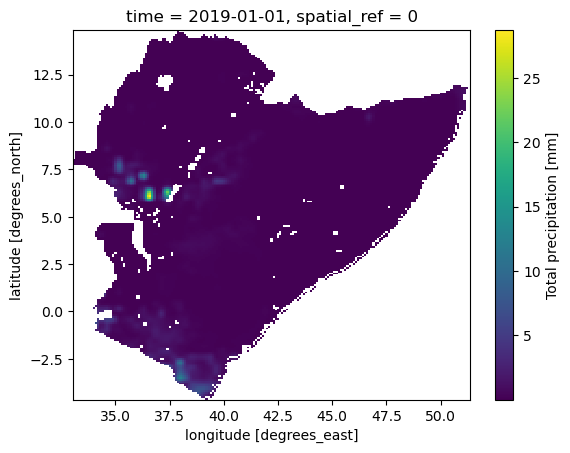

In [26]:
sub_precp.isel(time=0).plot()

In [24]:
data_x_unstack.isnull().sum().sum()

0

In [9]:
df = data_x_unstack["spi_gamma_60"][(14.625, 38.125)].reset_index()
df.columns=["date","value"]

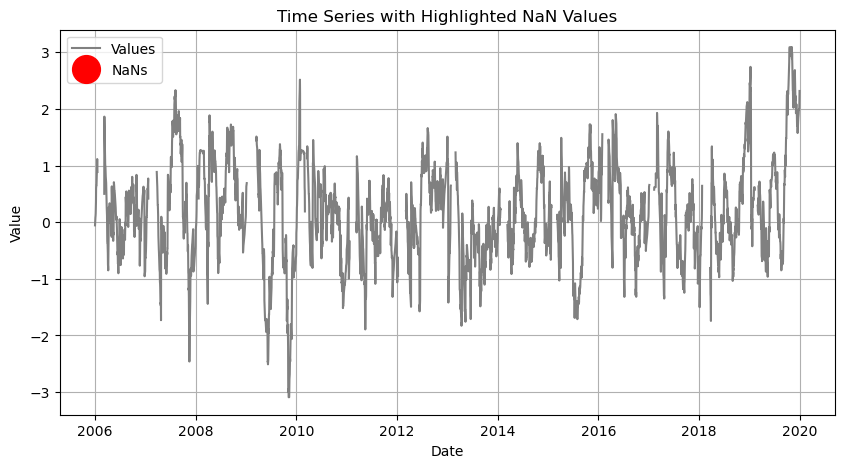

In [98]:
import pandas as pd
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['value'], color='grey', label='Values')
plt.plot(df['date'][df['value'].isnull()], df['value'][df['value'].isnull()], marker='o', color='red', label='NaNs', linestyle='None', markersize=20)

plt.title('Time Series with Highlighted NaN Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
df.reset_index()

,time,14.625
,,38.125
0,2006-01-01,-0.055441
1,2006-01-02,0.002709
2,2006-01-03,0.066991
3,2006-01-04,0.087555
4,2006-01-05,0.110299
...,...,...
5108,2019-12-27,1.991174
5109,2019-12-28,1.989494
5110,2019-12-29,2.008399


In [74]:
ds.sel(lat=14.625, lon=39.125).isnull().sum()

<xarray.DataArray 'ndvi' ()>
array(0)
Coordinates:
    lon          float64 39.12
    lat          float64 14.62
    spatial_ref  int64 0

In [61]:
data_y_unstack[data_y_unstack.isnull()]

ndvi                                                           \
lat         14.625                14.375                                      
lon         39.125 38.125 37.875  40.125 39.875 39.625 39.375 39.125 38.875   
time                                                                          
2006-01-01     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2006-01-02     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2006-01-03     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2006-01-04     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2006-01-05     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
...            ...    ...    ...     ...    ...    ...    ...    ...    ...   
2019-12-27     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2019-12-28     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2019-12-29     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2019-12-30     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2019-12-31     NaN    NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   

                   ...                                                     \
lat                ... -3.875         -4.125                                
lon        38.625  ...  38.375 38.125  39.625 39.375 39.125 38.875 38.625   
time               ...                                                      
2006-01-01    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2006-01-02    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2006-01-03    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2006-01-04    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2006-01-05    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
...           ...  ...     ...    ...     ...    ...    ...    ...    ...   
2019-12-27    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2019-12-28    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2019-12-29    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2019-12-30    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2019-12-31    NaN  ...     NaN    NaN     NaN    NaN    NaN    NaN    NaN   

                                   
lat        -4.375         -4.625   
lon         39.125 38.875  39.375  
time                               
2006-01-01     NaN    NaN     NaN  
2006-01-02     NaN    NaN     NaN  
2006-01-03     NaN    NaN     NaN  
2006-01-04     NaN    NaN     NaN  
2006-01-05     NaN    NaN     NaN  
...            ...    ...     ...  
2019-12-27     NaN    NaN     NaN  
2019-12-28     NaN    NaN     NaN  
2019-12-29     NaN    NaN     NaN  
2019-12-30     NaN    NaN     NaN  
2019-12-31     NaN    NaN     NaN  

[5113 rows x 2976 columns]

In [49]:
y_df2

,,,ndvi
time,lat,lon,
2019-12-31,14.625,39.125,0.135056
2019-12-30,14.625,39.125,0.150406
2019-12-29,14.625,39.125,0.161244
2019-12-28,14.625,39.125,0.166309
2019-12-27,14.625,39.125,0.169100
...,...,...,...
2006-01-05,-4.625,39.375,-0.029354
2006-01-04,-4.625,39.375,-0.029352
2006-01-03,-4.625,39.375,-0.007055


In [4]:
for i in [x_df, x_df_1, x_df_2, x_df_3, data_x_unstack]:
    print(len(i))

2990080
2990080
1877910
1877910
730


In [17]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import generate_adj_dist
adj_dist = generate_adj_dist(st_df)
seq_length_x = seq_length_y = 12
y_start = 1
x_offsets = np.sort(np.concatenate((np.arange(-(seq_length_x - 1), 1, 1),)))

with open(os.path.join(config["DEFAULT"]["data"], "graph_net/esa_adj_dist.pkl"), 'wb') as f:
        pickle.dump(adj_dist, f, protocol=2)

In [2]:
n_sub_precp, n_ds =  data_preparation(CONFIG_PATH, ndvi_dataset="smoothed_ndvi_1.nc")
n_x_df = n_sub_precp.to_dataframe()
n_x_df_1 = n_x_df.swaplevel(1,2)
n_x_df_2 = n_x_df_1.dropna(subset={"tp"}).drop(columns={"spatial_ref","crs"})
n_x_df_3 = n_x_df_2.sort_values(["lat", "lon","time"],ascending=False)
n_data_x_unstack = n_x_df_3.unstack(["lat","lon"])
#x_unstack = data_x_unstack.to_numpy()
n_num_samples, n_num_nodes = n_data_x_unstack.shape
n_x_unstack = np.expand_dims(n_data_x_unstack, axis=-1)
print("The features have dimensions:", n_x_unstack.shape)

The ERA5 raster has spatial dimensions: (0.10000000419197502, -0.1000000004915847)
NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
Precipitation dataset resolution (0.10000000419197502, -0.1000000004915847)
The features have dimensions: (730, 2552, 1)


In [3]:
for i in [n_x_df, n_x_df_1, n_x_df_2, n_x_df_3, n_data_x_unstack]:
    print(len(i))

2990080
2990080
1861850
1861850
730


In [4]:
n_y_df = n_ds.to_dataframe()
n_y_df = n_y_df.dropna(subset={"ndvi"}).drop(columns={"spatial_ref","crs"})
n_y_df = n_y_df.sort_values(["lat", "lon","time"],ascending=False)
n_y_df = n_y_df.reset_index().set_index(["time","lon","lat"])
n_y_df = n_y_df[n_y_df.index.isin(n_x_df_3.index)]
n_data_y_unstack = n_y_df.unstack(["lat","lon"])
n_y_unstack = n_data_y_unstack.to_numpy()
n_y_unstack = np.expand_dims(n_y_unstack, axis=-1)
print("The instance have dimensions:", n_y_unstack.shape)

### changes with features
n_st_df = n_x_df_3.reset_index()[["lon","lat"]].drop_duplicates()

The instance have dimensions: (730, 2552, 1)


In [73]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import generate_adj_dist
adj_dist = generate_adj_dist(n_st_df)
with open(os.path.join(config["DEFAULT"]["data"], "graph_net/n_adj_dist.pkl"), 'wb') as f:
        pickle.dump(adj_dist, f, protocol=2)

In [5]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import load_dataset, MetricsRecorder

output_dir = os.path.join(config["DEFAULT"]["data"],  "graph_net")
seq_length_x = seq_length_y = 12
y_start = 1
x_offsets = np.sort(np.concatenate((np.arange(-(seq_length_x - 1), 1, 1),)))

# Predict the next one hour
y_offsets = np.sort(np.arange(y_start, (seq_length_y + 1), 1))
x, y = [], []
min_t = abs(min(x_offsets))
max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive

for t in range(min_t, max_t):  # t is the index of the last observation.
    x.append(x_unstack[t + x_offsets, ...])
    y.append(y_unstack[t + y_offsets, ...])
x = np.stack(x, axis=0)
y = np.stack(y, axis=0)
print("x shape: ", x.shape, ", y shape: ", y.shape)
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train
x_train, y_train = x[:num_train], y[:num_train]
x_val, y_val = (
    x[num_train: num_train + num_val],
    y[num_train: num_train + num_val],
)
x_test, y_test = x[-num_test:], y[-num_test:]
for cat in ["train", "val", "test"]:
    _x, _y = locals()["x_" + cat], locals()["y_" + cat]
    print(cat, "x: ", _x.shape, "y:", _y.shape)
    np.savez_compressed(
        os.path.join(output_dir, f"{cat}.npz"),
        x=_x,
        y=_y,
        x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )
batch_size = config["GWNET"]["batch_size"]
dataloader = load_dataset(output_dir, batch_size, batch_size, batch_size)

x shape:  (707, 12, 2574, 1) , y shape:  (707, 12, 2574, 1)
train x:  (511, 12, 2574, 1) y: (511, 12, 2574, 1)
val x:  (73, 12, 2574, 1) y: (73, 12, 2574, 1)
test x:  (146, 12, 2574, 1) y: (146, 12, 2574, 1)


In [ ]:
import torch 
import time
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import save_figures, trainer, load_adj
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_length=12
nhid=32
in_dim =1
adjtype = "doubletransition"
learning_rate=0.001
dropout=0.3
weight_decay=0.0001
gcn_bool = "store_true"
addaptadj = "store_true"
print_every = 50
epochs = 50

adj_path = os.path.join(config["DEFAULT"]["data"], "graph_net/esa_adj_dist.pkl")
adj_mx = load_adj(adj_path,  adjtype)
scaler = dataloader['scaler']
supports = [torch.tensor(i).to(device) for i in adj_mx]
metrics_recorder = MetricsRecorder()
adjinit = supports[0]
engine = trainer(scaler, in_dim, seq_length, num_nodes, nhid, dropout,
                     learning_rate, weight_decay, device, supports, gcn_bool, addaptadj,
                     adjinit)
print("start training...",flush=True)
his_loss =[]
val_time = []
train_time = []
for i in range(1,epochs+1):
    train_loss = []
    train_mape = []
    train_rmse = []
    t1 = time.time()
    dataloader['train_loader'].shuffle()
    for iter, (x, y) in enumerate(dataloader['train_loader'].get_iterator()):
        trainx = torch.Tensor(x).to(device)
        trainx= trainx.transpose(1, 3)
        trainy = torch.Tensor(y).to(device)
        trainy = trainy.transpose(1, 3)
        metrics = engine.train(trainx, trainy[:,0,:,:])
        train_loss.append(metrics[0])
        train_mape.append(metrics[1])
        train_rmse.append(metrics[2])
        if iter % print_every == 0 :
            log = 'Iter: {:03d}, Train Loss: {:.4f}, Train MAPE: {:.4f}, Train RMSE: {:.4f}'
            print(log.format(iter, train_loss[-1], train_mape[-1], train_rmse[-1]),flush=True)
    t2 = time.time()
    train_time.append(t2-t1)
    #validation
    valid_loss = []
    valid_mape = []
    valid_rmse = []
    s1 = time.time()
    for iter, (x, y) in enumerate(dataloader['val_loader'].get_iterator()):
        testx = torch.Tensor(x).to(device)
        testx = testx.transpose(1, 3)
        testy = torch.Tensor(y).to(device)
        testy = testy.transpose(1, 3)
        metrics = engine.eval(testx, testy[:,0,:,:])
        valid_loss.append(metrics[0])
        valid_mape.append(metrics[1])
        valid_rmse.append(metrics[2])
    
    s2 = time.time()
    log = 'Epoch: {:03d}, Inference Time: {:.4f} secs'
    print(log.format(i,(s2-s1)))
    val_time.append(s2-s1)
    mtrain_loss = np.mean(train_loss)
    mtrain_mape = np.mean(train_mape)
    mtrain_rmse = np.mean(train_rmse)
    metrics_recorder.add_train_metrics(mtrain_mape, mtrain_rmse, mtrain_loss)
    mvalid_loss = np.mean(valid_loss)
    mvalid_mape = np.mean(valid_mape)
    mvalid_rmse = np.mean(valid_rmse)
    his_loss.append(mvalid_loss)
    metrics_recorder.add_val_metrics(mvalid_mape, mvalid_rmse, mvalid_loss)
    save_figures(config=config, epoch=i, train_loss=metrics_recorder.train_loss, 
                train_mape=metrics_recorder.train_mape, train_rmse=metrics_recorder.train_rmse, 
                test_loss=metrics_recorder.val_loss, test_rmse=metrics_recorder.val_loss, 
                test_mape=metrics_recorder.val_mape)
    log = 'Epoch: {:03d}, Train Loss: {:.4f}, Train MAPE: {:.4f}, Train RMSE: {:.4f}, Valid Loss: {:.4f}, Valid MAPE: {:.4f}, Valid RMSE: {:.4f}, Training Time: {:.4f}/epoch'
    print(log.format(i, mtrain_loss, mtrain_mape, mtrain_rmse, mvalid_loss, mvalid_mape, mvalid_rmse, (t2 - t1)),flush=True)
    #torch.save(engine.model.state_dict(), args.save+"_epoch_"+str(i)+"_"+str(round(mvalid_loss,2))+".pth")
print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))

In [22]:
# Open the precipitation file with xarray
from p_drought_indices.functions.function_clns import load_config, prepare, subsetting_pipeline, get_lat_lon_window
import xarray as xr

CONFIG_PATH = "../config.yaml"

config = load_config(CONFIG_PATH)
path = config['PRECIP']['CHIRPS']['path']
file = "CHIRPS_merged.nc"
precp_dataset = "CHIRPS"

precp_ds = prepare(subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(path, file))))\
        .rio.write_crs(4326, inplace=True)

In [123]:
del precp_ds["pr"].attrs["grid_mapping"]

precp_ds.sel(time=slice(precp_ds["time"].min(), "2019-12-31"))\
    .to_netcdf(os.path.join(path, "CHIRPS_merged.nc"))

In [125]:
precp_ds["pr"].attrs

{'standard_name': 'lwe_precipitation_rate',
 'long_name': 'total daily precipitation',
 'units': 'mm'}

In [109]:
var_target = [var for var in precp_ds.data_vars][0]

precp_ds[var_target] = precp_ds[var_target].astype(np.float32)
#time_end = config['DEFAULT']['date_end']
#time_start = config['DEFAULT']['date_start']
time_end = config['PRECIP'][precp_dataset]['date_end']
time_start = config['PRECIP'][precp_dataset]['date_start']
dim = config["GWNET"]["pixels"]
# Open the vegetation file with xarray
dataset = prepare(xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], "smoothed_ndvi_1_old.nc"))).rio.write_crs(4326, inplace=True)
dataset["ndvi"] = dataset["ndvi"].astype(np.float32)
dataset = dataset.sel(time=slice(time_start,time_end))[["time","lat","lon","ndvi"]]


idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)
sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
        .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))
ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})
sub_precp, ds = check_time_arrays(sub_precp[var_target], ds)
sub_precp = sub_precp.where(ds.notnull())

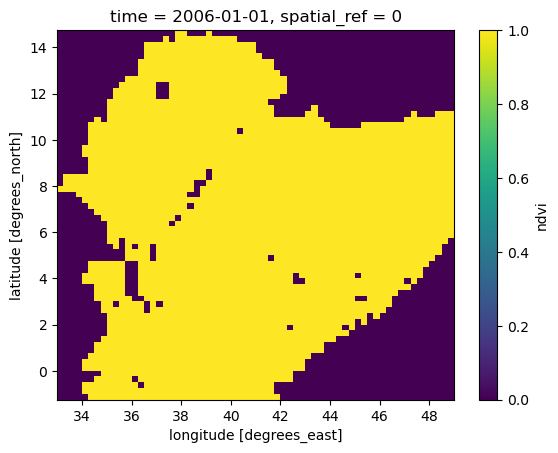

In [80]:
xr.where(ds.notnull(),1,0).isel(time=0).plot()

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='time', length=5113, freq='D')

In [81]:
sub_precp[var_target].where(~np.isnan(ds))

<xarray.DataArray 'pr' (time: 0, lat: 64, lon: 64)>
array([], shape=(0, 64, 64), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 
  * lon          (lon) float64 33.12 33.38 33.62 33.88 ... 48.38 48.62 48.88
  * lat          (lat) float64 14.62 14.38 14.12 13.88 ... -0.625 -0.875 -1.125
    spatial_ref  int64 0
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      total daily precipitation
    units:          mm
    grid_mapping:   spatial_ref

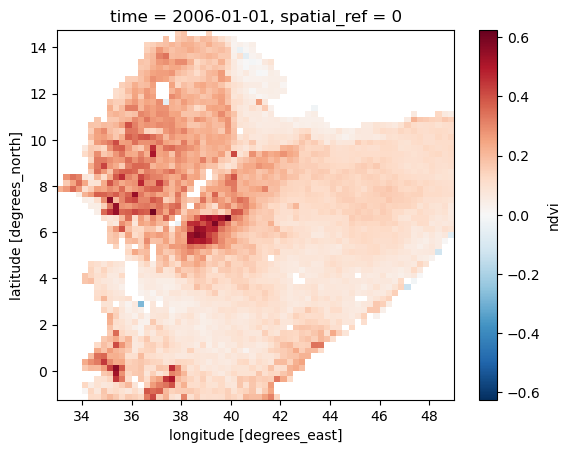

In [67]:
ds.isel(time=0).plot()

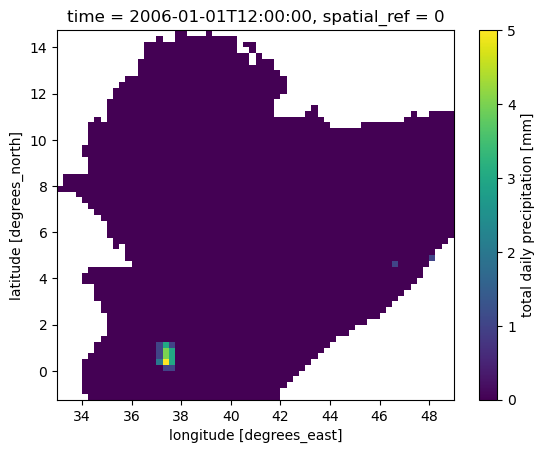

In [66]:
sub_precp[var_target].isel(time=0).plot()

In [42]:
ds

<xarray.DataArray 'ndvi' (time: 5113, lat: 64, lon: 64)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 33.12 33.38 33.62 33.88 ... 48.38 48.62 48.88
  * lat          (lat) float64 14.62 14.38 14.12 13.88 ... -0.625 -0.875 -1.125
  * time         (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2019-12-31
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

In [40]:
ds

<xarray.DataArray 'ndvi' (time: 5113, lat: 64, lon: 64)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 33.12 33.38 33.62 33.88 ... 48.38 48.62 48.88
  * lat          (lat) float64 14.62 14.38 14.12 13.88 ... -0.625 -0.875 -1.125
  * time         (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2019-12-31
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38